# Preprocessing

We apply the same preprocessing steps from Chapter 1 to our new set of data. We do not retrain our models but we import the models that we trained on our previous data and model returns on a fresh, out-of-sample dataset. This allows us to assess results in an unbiased fashion.

Based on our results in the previous chapter, we will test the three approaches with the most promising results: Random Forest, ARIMA and RLRT

Number of ETFs: 585
Number of timestamps: 250
                            AADR   AAXJ  ABCS   ACWI   ACWX
Timestamp                                                  
2023-01-03 05:00:00+00:00  47.19  65.67   NaN  84.90  45.80
2023-01-04 05:00:00+00:00  47.53  67.92   NaN  85.98  46.70
2023-01-05 05:00:00+00:00  47.34  67.56   NaN  85.10  46.30
2023-01-06 05:00:00+00:00  48.10  68.77   NaN  87.07  47.39
2023-01-09 05:00:00+00:00  48.29  69.29   NaN  87.26  47.62
AAXJ     0.0
ABCS    97.2
ACWI     0.0
ACWX     0.0
AGNG     0.0
        ... 
XBIL    17.2
XFIX    67.6
XT       0.0
YLDE     0.0
ZZZ     99.2
Length: 584, dtype: float64


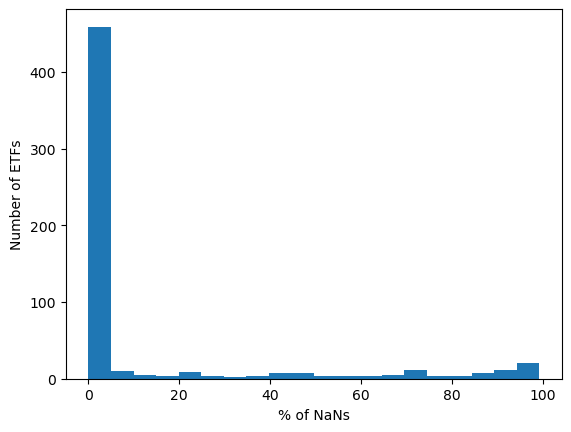

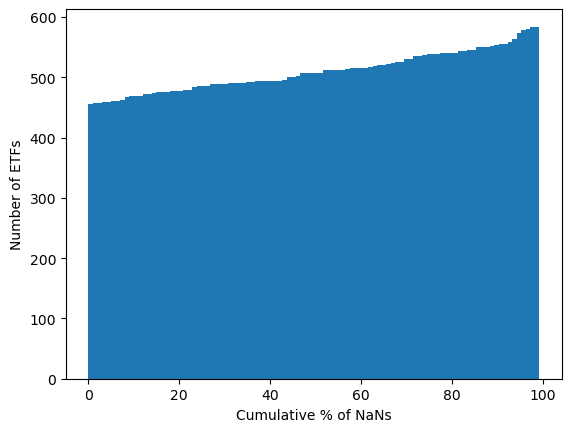

Number of valid ETFs: 451
Number of valid ETFs: 451


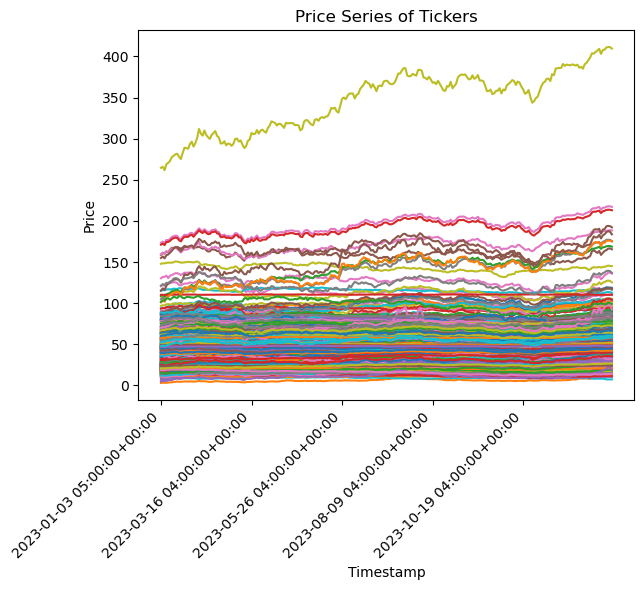

                               AAXJ      ACWI      ACWX      AGNG      AGZD
Timestamp                                                                  
2023-01-04 05:00:00+00:00  0.034262  0.012721  0.019651  0.008779  0.002421
2023-01-05 05:00:00+00:00 -0.005300 -0.010235 -0.008565 -0.005311  0.001495
2023-01-06 05:00:00+00:00  0.017910  0.023149  0.023542  0.019947 -0.000689
2023-01-09 05:00:00+00:00  0.007561  0.002182  0.004853 -0.010269  0.001379
2023-01-10 05:00:00+00:00  0.006206  0.005615  0.004620  0.007508  0.000803


In [21]:
# Imports, read and preview data

import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import linregress

df = pd.read_csv("../../data/etf_prices_backtest.csv")
df.set_index("Timestamp", inplace=True)

print(f"Number of ETFs: {df.shape[1]}\nNumber of timestamps: {df.shape[0]}")
print(df.iloc[:,:5].head())

# Percentage of NaN values per ticker

nan_percentages = df.isna().mean()[1:] * 100
print(nan_percentages)

# Distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=False, bins=20)
plt.xlabel("% of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

# Cumulative distribution of percentage of NaN values

plt.hist(nan_percentages, cumulative=True, bins=100)
plt.xlabel("Cumulative % of NaNs")
plt.ylabel("Number of ETFs")
plt.show()

# Drop series with more than 25% NaN values

valid_etfs = nan_percentages[nan_percentages == 0]
df = df[valid_etfs.index]

print(f"Number of valid ETFs: {len(valid_etfs)}")

# Drop series if first or last value is NaN

valid_columns = df.columns[df.iloc[0].notna() & df.iloc[-1].notna()]
df = df[valid_columns]

print(f"Number of valid ETFs: {len(valid_columns)}")

for column in df.columns:
    plt.plot(df.index, df[column], label=column)

    # Add labels and legend
plt.xlabel('Timestamp')
plt.ylabel('Price')
plt.title('Price Series of Tickers')
num_ticks = 5  # Specify the number of ticks you want to display
plt.xticks(df.index[::len(df.index)//num_ticks])
plt.xticks(rotation=45, ha='right')
plt.show()

# Compute returns

df_returns = df.pct_change().iloc[1:]
print(df_returns.iloc[:,:5].head())

# Save variables in a pickle file

with open('../../data/ch3_etfs_backtest.pkl', 'wb') as f:
    pickle.dump([df, df_returns], f)

In [28]:
import pickle
import numpy as np
import pandas as pd

with open('../../data/ch3_IXUS_VXUS_random_forest.pkl', 'rb') as f:
    rf_model = pickle.load(f)

with open('../../data/ch3_etfs_backtest.pkl', 'rb') as f:
    df, df_returns = pickle.load(f)

# print(df.iloc[:,:5].tail())
# print(df_returns.head())

ticker_1 = 'IXUS'
ticker_2 = 'VXUS'

df = df[[ticker_1,ticker_2]]
print(df.head())

                            IXUS   VXUS
Timestamp                              
2023-01-03 05:00:00+00:00  58.30  52.07
2023-01-04 05:00:00+00:00  59.34  52.96
2023-01-05 05:00:00+00:00  58.80  52.50
2023-01-06 05:00:00+00:00  60.23  53.73
2023-01-09 05:00:00+00:00  60.49  54.02


# Random Forest

Using the random forest model we trained earlier, we assess the results of the model on our new data. This yields sub par results, indicating a possible case of overfitting.

In [29]:
evaluation_dict = {}

evaluation_dict["Name"] = f'{ticker_1} and {ticker_2}'

ticker_series_1 = df[ticker_1]
ticker_series_2 = df[ticker_2]

slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

data = spread.values

# Normalize data, split train and test, create sequences and reshape them for model

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data.reshape(-1, 1)).reshape(-1)

print(type(data))
print(spread.index)

def create_lagged_features(series, lags=5):
    spread = pd.Series(series, name='spread')
    df = pd.DataFrame(spread)
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['spread'].shift(lag)
    df.dropna(inplace=True)
    return df

lags = 5
lagged_df = create_lagged_features(data, lags=lags)

# Split into train and test sets

X = lagged_df.drop(columns=['spread'])
y = lagged_df['spread']

rf_predictions = rf_model.predict(X)

rf_mse = mean_squared_error(y, rf_predictions)
rf_mae = mean_absolute_error(y, rf_predictions)
evaluation_dict["Random Forest MSE"] = rf_mse
evaluation_dict["Random Forest MAE"] = rf_mae



<class 'numpy.ndarray'>
Index(['2023-01-03 05:00:00+00:00', '2023-01-04 05:00:00+00:00',
       '2023-01-05 05:00:00+00:00', '2023-01-06 05:00:00+00:00',
       '2023-01-09 05:00:00+00:00', '2023-01-10 05:00:00+00:00',
       '2023-01-11 05:00:00+00:00', '2023-01-12 05:00:00+00:00',
       '2023-01-13 05:00:00+00:00', '2023-01-17 05:00:00+00:00',
       ...
       '2023-12-15 05:00:00+00:00', '2023-12-18 05:00:00+00:00',
       '2023-12-19 05:00:00+00:00', '2023-12-20 05:00:00+00:00',
       '2023-12-21 05:00:00+00:00', '2023-12-22 05:00:00+00:00',
       '2023-12-26 05:00:00+00:00', '2023-12-27 05:00:00+00:00',
       '2023-12-28 05:00:00+00:00', '2023-12-29 05:00:00+00:00'],
      dtype='object', name='Timestamp', length=250)


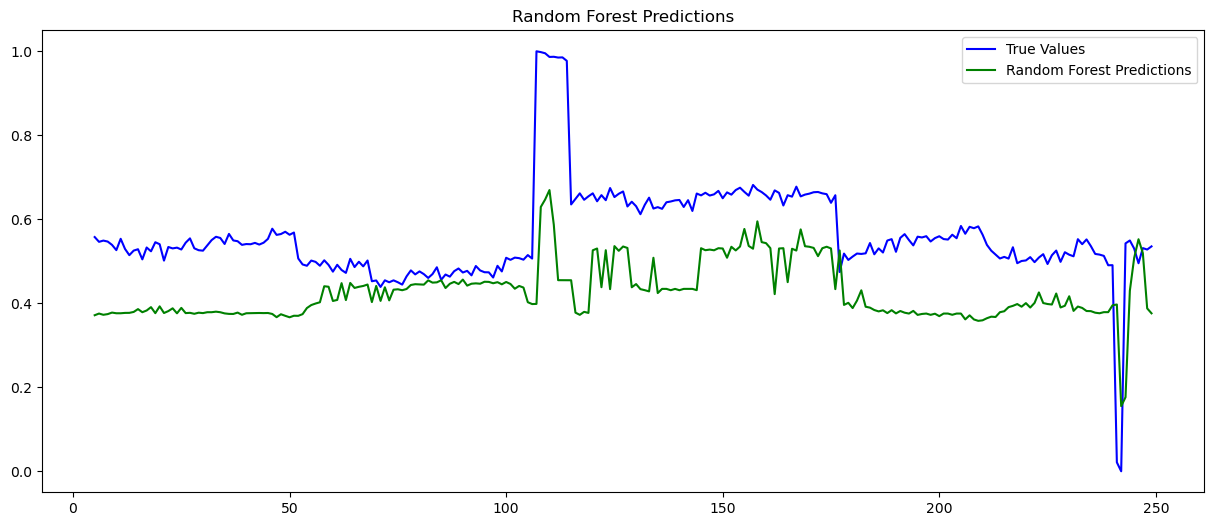

{'Name': 'IXUS and VXUS', 'Random Forest MSE': 0.02777901224925362, 'Random Forest MAE': 0.14198454038747388, 'Random Forest Trend Accuracy': 0.5256410256410257}


In [30]:
# Example: Plot the results

plt.figure(figsize=(15, 6))
plt.title('Random Forest Predictions')
plt.plot(y.index, y, label='True Values', color='blue')
plt.plot(y.index, rf_predictions, label='Random Forest Predictions', color='green')
plt.legend()
plt.show()

# Random Forest Directional Accuracy

trend_rf = []
for i in range(1, len(y)-10):
    if rf_predictions[i] > y.iloc[i-1]:
        trend_rf.append(1)
    elif rf_predictions[i] < y.iloc[i-1]:
        trend_rf.append(-1)
    else:
        trend_rf.append(0)

trend_rf_true = []
for i in range(1, len(y)-10):
    if y.iloc[i] > y.iloc[i-1]:
        trend_rf_true.append(1)
    elif y.iloc[i] < y.iloc[i-1]:
        trend_rf_true.append(-1)
    else:
        trend_rf_true.append(0)

accuracy_trend = [trend_rf[i] == trend_rf_true[i] for i in range(len(trend_rf))] 
evaluation_dict["Random Forest Trend Accuracy"] = np.sum(accuracy_trend)/len(accuracy_trend)

print(evaluation_dict)

# ARIMA

Again, we import the ARIMA model from the previous chapter, compute success criteria and plot results. Especially for ARIMA, we see that the predictions are just a lagged version of the actual values. This indicates that the model is struggling to display any form of learning. The grave difference between train and test results also indicates a case of overfitting.

Processed 0/247 data points
Processed 100/247 data points
Processed 200/247 data points
Mean Squared Error: 0.02519216077223974
Mean Absolute Error: 0.13649142197639805


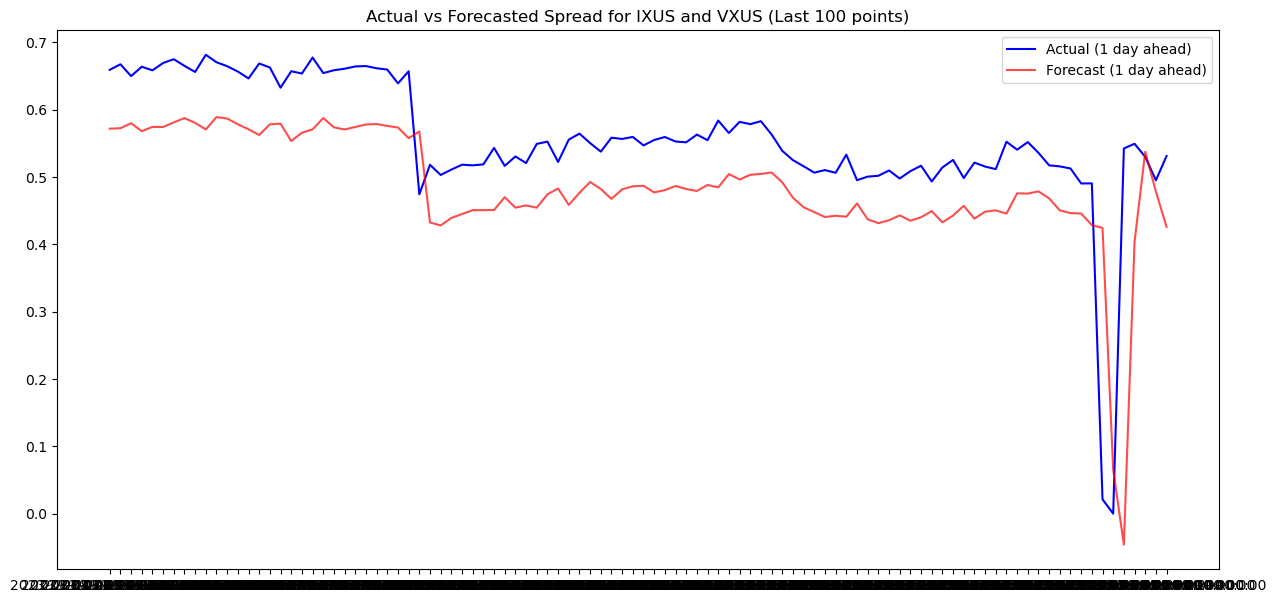

Trend Accuracy (1 day ahead): 35.77%
Rolling forecast completed and results added to evaluation_dict.


In [31]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMAResults
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Load the saved model
with open(f'../../data/ch3_{ticker_1}_{ticker_2}_arima.pkl', 'rb') as f:
    model = pickle.load(f)

# Initialize lists to store forecasts and actual values
all_forecasts = []
actual_values = []

# Function to make a 3-day forecast
def forecast_next_3_days(model, last_data_point):
    forecast = model.forecast(steps=3)
    return forecast

# Perform rolling forecast
for i in range(len(data) - 3):  # -3 to ensure we have actual values to compare with forecasts
    # Get the current data point
    current_data = data[i]
    
    # Update the model with the current data point
    model = model.append([current_data])
    
    # Make the forecast
    forecast = forecast_next_3_days(model, current_data)
    
    # Store the forecast and actual values
    all_forecasts.append(forecast)
    actual_values.append(data[i+1:i+4])  # Next 3 actual values

    if i % 100 == 0:  # Print progress every 100 iterations
        print(f"Processed {i}/{len(data)-3} data points")

# Convert forecasts and actual values to numpy arrays
all_forecasts = np.array(all_forecasts)
actual_values = np.array(actual_values)

# Calculate accuracy metrics
mse = mean_squared_error(actual_values.ravel(), all_forecasts.ravel())
mae = mean_absolute_error(actual_values.ravel(), all_forecasts.ravel())

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

# Plot actual vs forecasted values for the last 100 data points
plt.figure(figsize=(15, 7))
last_100_index = spread.index[-103:-3]  # Adjust index for the last 100 points
plt.plot(last_100_index, actual_values[-100:, 0], label='Actual (1 day ahead)', color='blue')
plt.plot(last_100_index, all_forecasts[-100:, 0], label='Forecast (1 day ahead)', color='red', alpha=0.7)
plt.title(f'Actual vs Forecasted Spread for {ticker_1} and {ticker_2} (Last 100 points)')
plt.legend()
plt.show()

# Calculate trend accuracy
def calculate_trend(data):
    return np.sign(np.diff(data))

actual_trends = calculate_trend(actual_values[:, 0])
forecast_trends = calculate_trend(all_forecasts[:, 0])

trend_accuracy = np.mean(actual_trends == forecast_trends)
print(f"Trend Accuracy (1 day ahead): {trend_accuracy:.2%}")

# Add results to evaluation_dict
evaluation_dict["ARIMA MSE"] = mse
evaluation_dict["ARIMA MAE"] = mae
evaluation_dict["ARIMA Trend Accuracy"] = trend_accuracy

print("Rolling forecast completed and results added to evaluation_dict.")

# RLRT

Our most promising model so far, probably because we do not pre-train a model but fit values into a new model in a rolling window fashion. We run our backtesting window data through the model, compute success metrics and plot results. We see that we achieve similar results to our testing period.


Results for R² threshold 0.4:
Accuracy: 79.01%
Total signals: 81
Correct predictions: 64
Accuracy of generated signals: 79.01%
Average R² Confidence: 0.3002

Results for R² threshold 0.5:
Accuracy: 84.21%
Total signals: 57
Correct predictions: 48
Accuracy of generated signals: 84.21%
Average R² Confidence: 0.3002

Results for R² threshold 0.6:
Accuracy: 86.84%
Total signals: 38
Correct predictions: 33
Accuracy of generated signals: 86.84%
Average R² Confidence: 0.3002


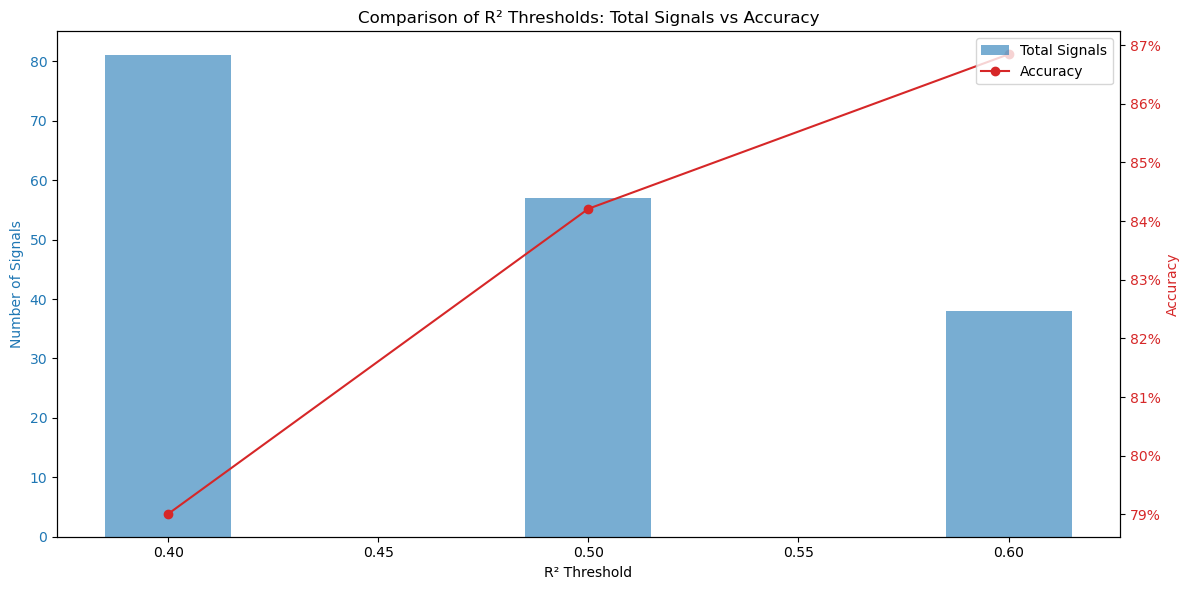

Threshold comparison plot with thin bars created.

Best performing threshold: 0.6


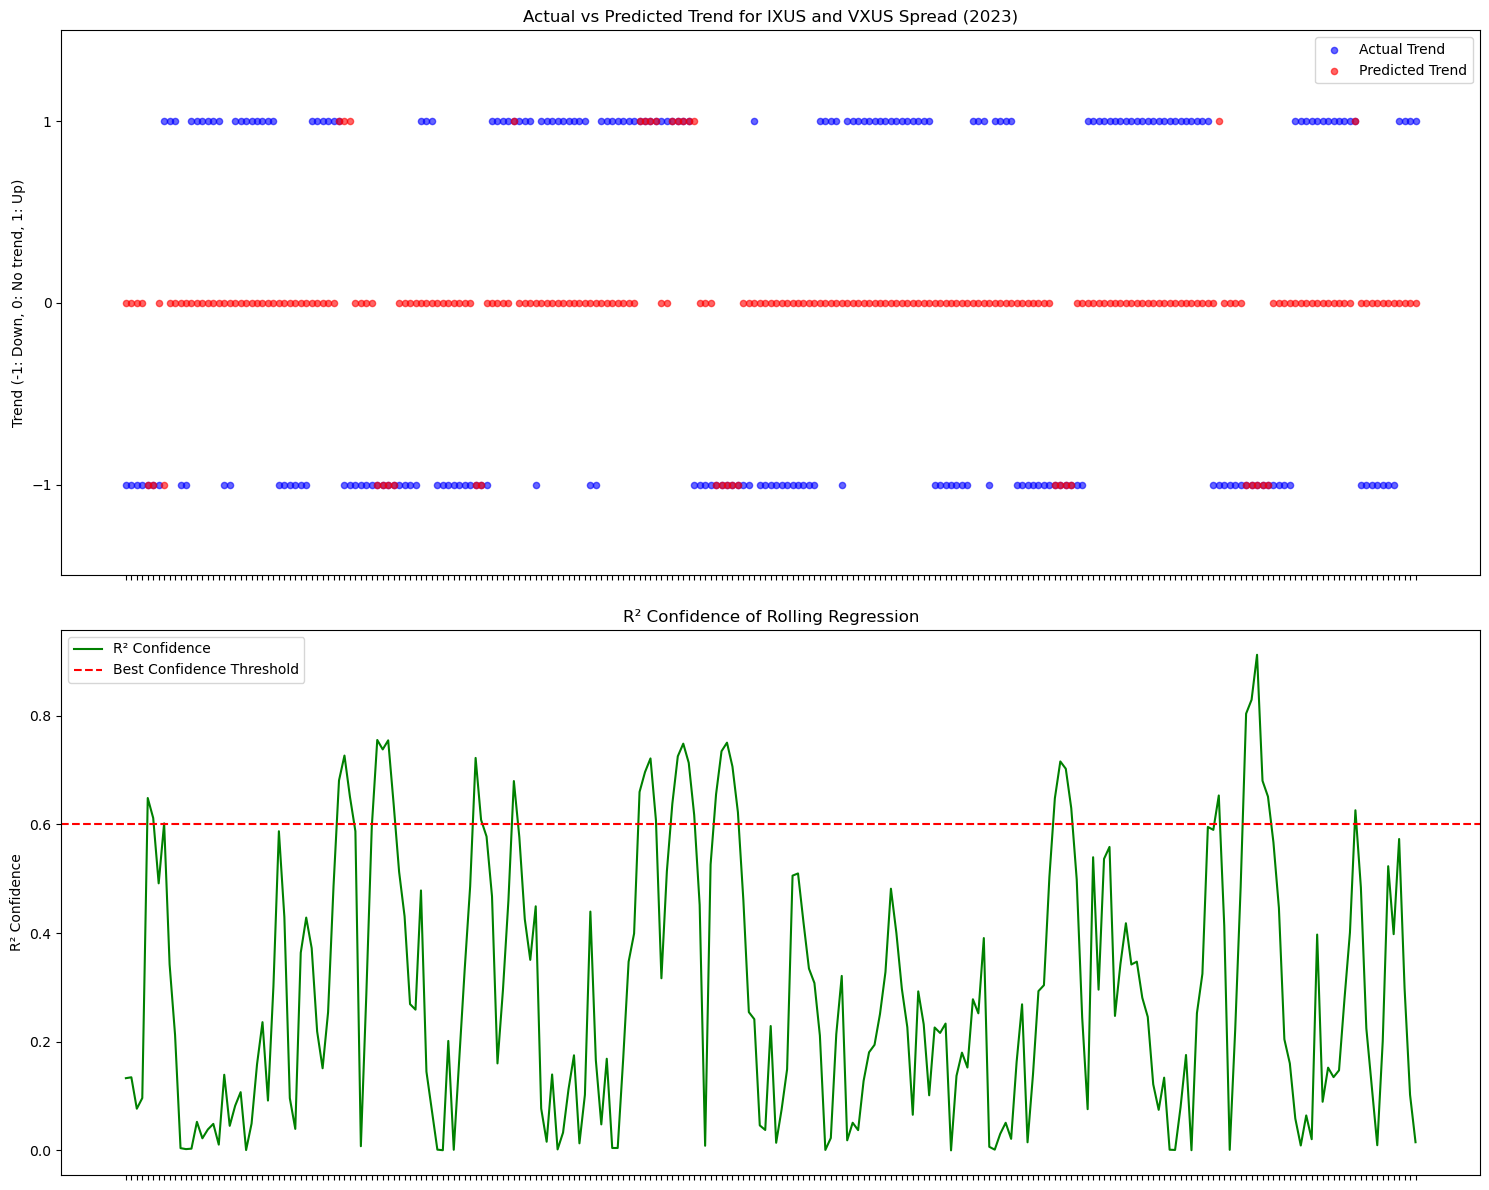

Actual vs Predicted Trend scatter plot created without x-axis labels.
Actual vs Predicted Trend scatter plot created.
Threshold optimization completed.


In [32]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, accuracy_score
import matplotlib.pyplot as plt

def rolling_regression_trend_with_confidence(data, window_size=10, forecast_days=3, r2_threshold=0.5):
    trends = []
    confidences = []
    for i in range(window_size, len(data) - forecast_days + 1):
        X = np.arange(window_size).reshape(-1, 1)
        y = data[i-window_size:i]
        model = LinearRegression()
        model.fit(X, y)
        
        r2 = r2_score(y, model.predict(X))
        
        if r2 > r2_threshold:
            trend = 1 if model.coef_[0] > 0 else -1 if model.coef_[0] < 0 else 0
        else:
            trend = 0
        
        trends.append(trend)
        confidences.append(r2)
    return np.array(trends), np.array(confidences)

def actual_trend(data, window_size=10, forecast_days=3):
    trends = []
    for i in range(window_size, len(data) - forecast_days + 1):
        past_avg = np.mean(data[i-window_size:i])
        future_avg = np.mean(data[i:i+forecast_days])
        trend = 1 if future_avg > past_avg else -1 if future_avg < past_avg else 0
        trends.append(trend)
    return np.array(trends)

def evaluate_threshold(data, actual_trends, r2_threshold):
    predicted_trends, confidences = rolling_regression_trend_with_confidence(data, r2_threshold=r2_threshold)
    
    non_zero_predictions = predicted_trends != 0
    accuracy = accuracy_score(actual_trends[non_zero_predictions], predicted_trends[non_zero_predictions])
    
    total_predictions = sum(predicted_trends != 0)
    correct_predictions = sum((predicted_trends == actual_trends) & (predicted_trends != 0))
    accuracy_percentage = (correct_predictions / total_predictions * 100) if total_predictions > 0 else 0
    
    return {
        'threshold': r2_threshold,
        'accuracy': accuracy,
        'total_signals': total_predictions,
        'correct_predictions': correct_predictions,
        'accuracy_percentage': accuracy_percentage,
        'average_confidence': np.mean(confidences)
    }

# Ensure data and index have the same length
min_length = min(len(data), len(spread.index))
data = data[:min_length]
dates = spread.index[:min_length]

# Calculate actual trends
actual_trends = actual_trend(data)

# Test different thresholds
thresholds = [0.4, 0.5, 0.6]
results = []

for threshold in thresholds:
    result = evaluate_threshold(data, actual_trends, threshold)
    results.append(result)
    print(f"\nResults for R² threshold {threshold}:")
    print(f"Accuracy: {result['accuracy']:.2%}")
    print(f"Total signals: {result['total_signals']}")
    print(f"Correct predictions: {result['correct_predictions']}")
    print(f"Accuracy of generated signals: {result['accuracy_percentage']:.2f}%")
    print(f"Average R² Confidence: {result['average_confidence']:.4f}")

total_signals = [result['total_signals'] for result in results]
accuracies = [result['accuracy'] for result in results]

# Plot comparison of thresholds
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot total signals on the left y-axis with thinner bars
color = 'tab:blue'
bar_width = 0.03  # Adjust this value to make bars thinner or thicker
ax1.set_xlabel('R² Threshold')
ax1.set_ylabel('Number of Signals', color=color)
ax1.bar(thresholds, total_signals, width=bar_width, alpha=0.6, color=color, label='Total Signals')
ax1.tick_params(axis='y', labelcolor=color)

# Create a secondary y-axis for accuracy
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Accuracy', color=color)
ax2.plot(thresholds, accuracies, color=color, marker='o', label='Accuracy')
ax2.tick_params(axis='y', labelcolor=color)

# Set the accuracy y-axis to percentage format
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

# Title and legend
plt.title('Comparison of R² Thresholds: Total Signals vs Accuracy')
fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)

# Adjust layout and display
plt.tight_layout()
plt.show()

print("Threshold comparison plot with thin bars created.")

# Plot trends and confidence for the best performing threshold
best_threshold = max(results, key=lambda x: x['accuracy'])['threshold']
print(f"\nBest performing threshold: {best_threshold}")

predicted_trends, confidences = rolling_regression_trend_with_confidence(data, r2_threshold=best_threshold)

# Ensure all arrays have the same length for plotting
min_length = min(len(predicted_trends), len(actual_trends), len(dates) - 13)
predicted_trends = predicted_trends[:min_length]
actual_trends = actual_trends[:min_length]
confidences = confidences[:min_length]
plot_dates = dates[13:13+min_length]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Scatter plot for actual trends
ax1.scatter(plot_dates, actual_trends, label='Actual Trend', color='blue', alpha=0.6, s=20)
# Scatter plot for predicted trends
ax1.scatter(plot_dates, predicted_trends, label='Predicted Trend', color='red', alpha=0.6, s=20)

ax1.set_title(f'Actual vs Predicted Trend for {ticker_1} and {ticker_2} Spread (2023)')
ax1.set_ylabel('Trend (-1: Down, 0: No trend, 1: Up)')
ax1.legend()
ax1.set_ylim(-1.5, 1.5)  # Set y-axis limits to better show the discrete values
ax1.set_yticks([-1, 0, 1])  # Set y-axis ticks to show only the possible trend values

# Plot for R² confidence
ax2.plot(plot_dates, confidences, label='R² Confidence', color='green')
ax2.axhline(y=best_threshold, color='r', linestyle='--', label='Best Confidence Threshold')
ax2.set_title('R² Confidence of Rolling Regression')
ax2.set_ylabel('R² Confidence')
ax2.legend()

# Remove x-axis labels from both subplots
plt.setp(ax1.get_xticklabels(), visible=False)
plt.setp(ax2.get_xticklabels(), visible=False)

# Adjust layout to remove extra space
plt.tight_layout()
plt.subplots_adjust(hspace=0.1)  # Reduce space between subplots

plt.show()

print("Actual vs Predicted Trend scatter plot created without x-axis labels.")

print("Actual vs Predicted Trend scatter plot created.")

print("Threshold optimization completed.")

                                                Date    Spread  \
Timestamp                                                        
2023-01-03 05:00:00+00:00  2023-01-03 05:00:00+00:00  0.568518   
2023-01-04 05:00:00+00:00  2023-01-04 05:00:00+00:00  0.543929   
2023-01-05 05:00:00+00:00  2023-01-05 05:00:00+00:00  0.557906   
2023-01-06 05:00:00+00:00  2023-01-06 05:00:00+00:00  0.527671   
2023-01-09 05:00:00+00:00  2023-01-09 05:00:00+00:00  0.560130   
2023-01-10 05:00:00+00:00  2023-01-10 05:00:00+00:00  0.557684   
2023-01-11 05:00:00+00:00  2023-01-11 05:00:00+00:00  0.546318   
2023-01-12 05:00:00+00:00  2023-01-12 05:00:00+00:00  0.549242   
2023-01-13 05:00:00+00:00  2023-01-13 05:00:00+00:00  0.546961   
2023-01-17 05:00:00+00:00  2023-01-17 05:00:00+00:00  0.539053   
2023-01-18 05:00:00+00:00  2023-01-18 05:00:00+00:00  0.526529   
2023-01-19 05:00:00+00:00  2023-01-19 05:00:00+00:00  0.553527   
2023-01-20 05:00:00+00:00  2023-01-20 05:00:00+00:00  0.529453   
2023-01-23

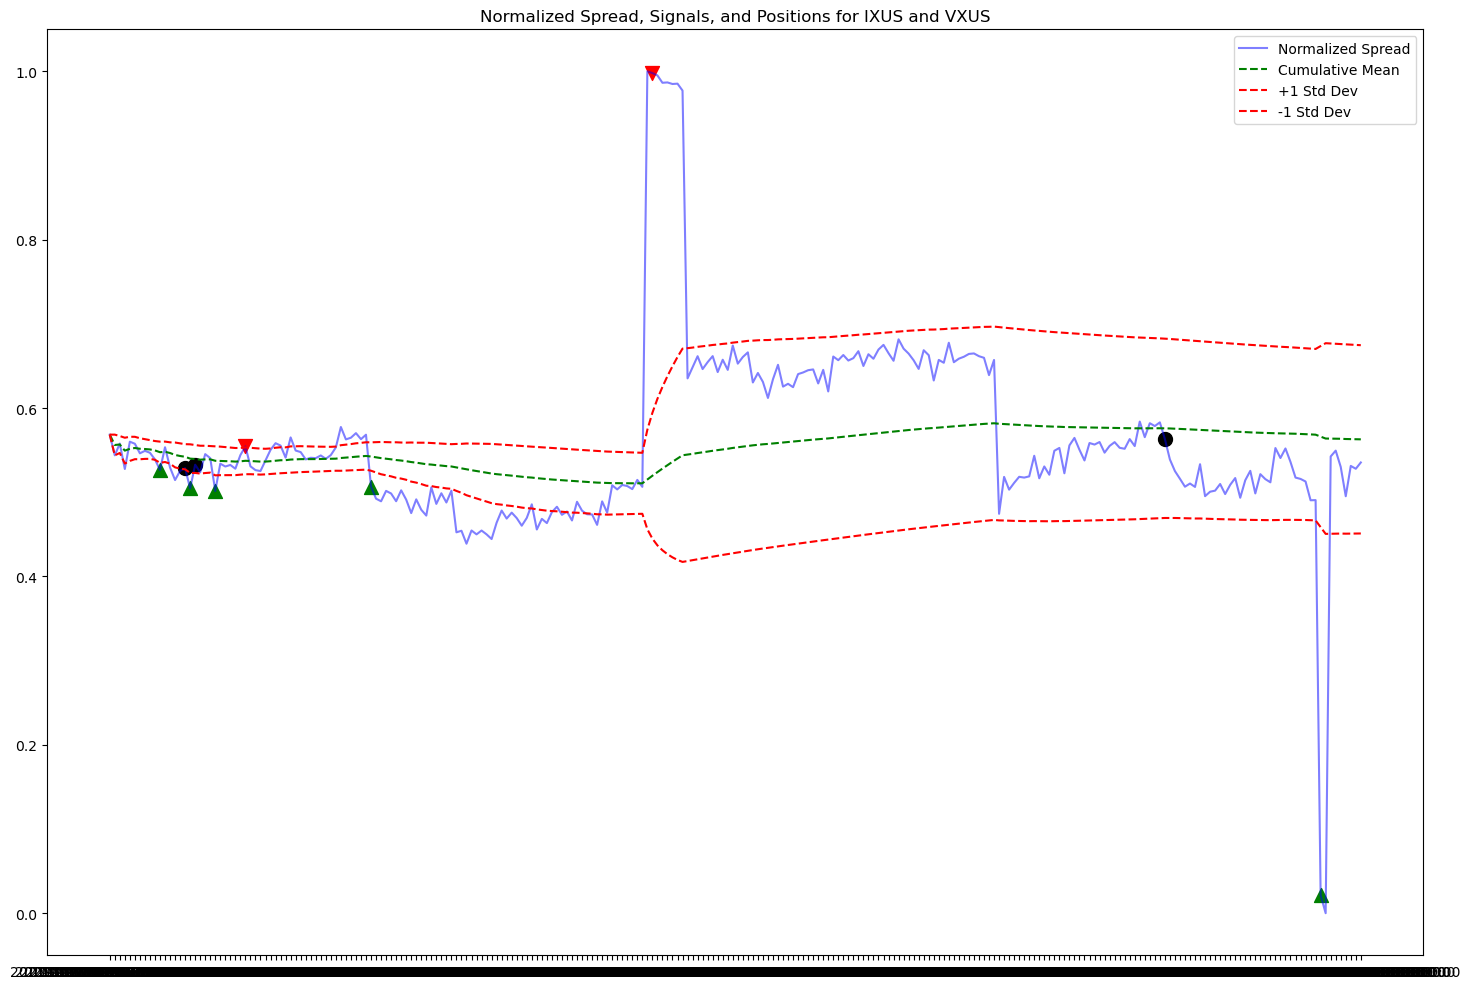

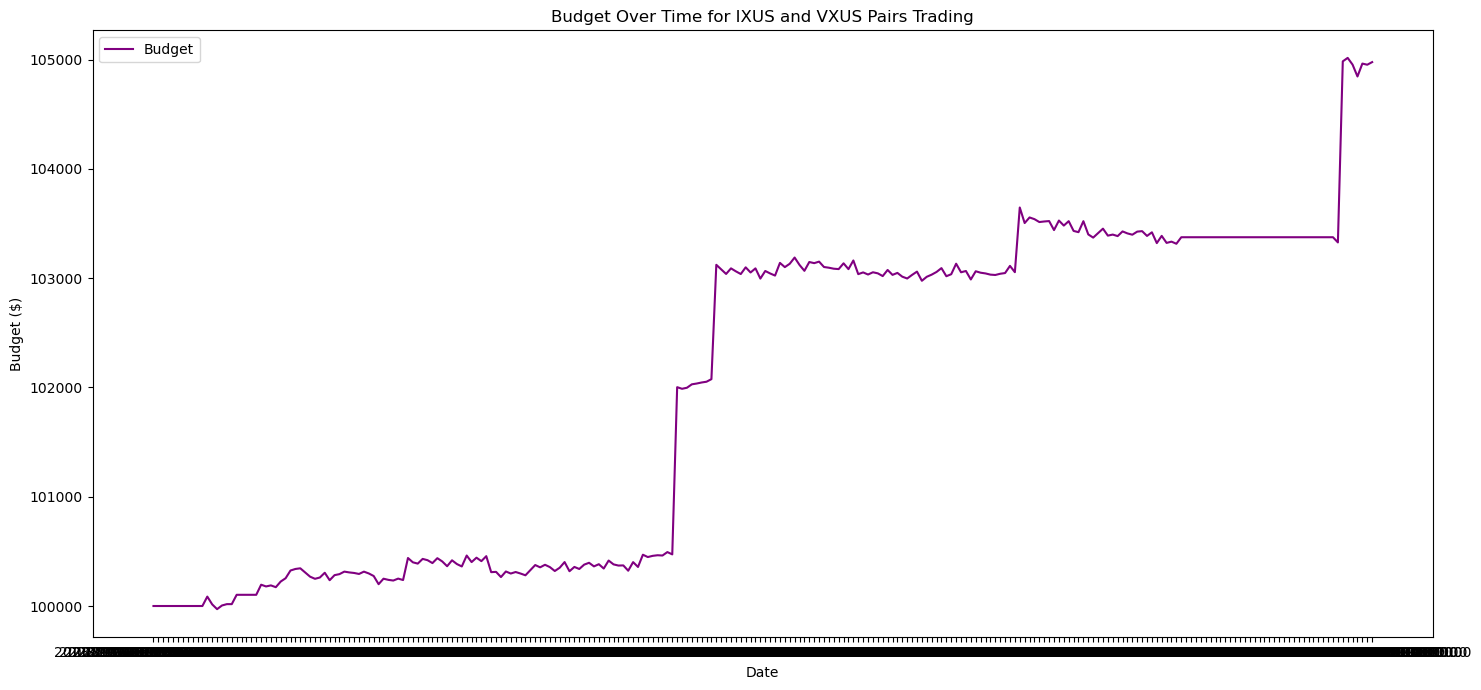


Signal Statistics:
Total Signals: 72
Long Signals: 42
Short Signals: 9
Exit Long Signals: 16
Exit Short Signals: 5

Position Statistics:
Long Positions: 77
Short Positions: 127
Neutral Positions: 46

Trading Strategy Statistics:
Time Period: 2023-01-03 to 2023-12-29 (0.99 years)
Starting Budget: $100000.00
Ending Budget: $104976.57
Total Return: 4.98%
Annualized Return: 5.05%
Maximum Drawdown: -0.32%
Sharpe Ratio: 1.90
Budget-based return calculation completed.


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.preprocessing import MinMaxScaler

# Calculate the spread and normalize it
ticker_series_1 = df[ticker_1]
ticker_series_2 = df[ticker_2]

slope, intercept, _, _, _ = linregress(ticker_series_1, ticker_series_2)
spread = ticker_series_2 - (slope * ticker_series_1 + intercept)

scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(spread.values.reshape(-1, 1)).reshape(-1)

# Initialize parameters
initial_budget = 100000
dates = df.index

# Define window size
window_size = 10

# Initialize lists for signals, positions, and budget
signals = ['None'] * len(data)
positions = [0] * len(data)
budgets = [initial_budget] * len(data)

# Initialize lists to keep track of cumulative mean and std
cumulative_mean = np.zeros(len(data))
cumulative_std = np.zeros(len(data))

# Create a new list for padded predictions
padded_predictions = [None] * window_size + list(predicted_trends)
if len(padded_predictions) < len(data):
    padded_predictions.extend([None] * (len(data) - len(padded_predictions)))
else:
    padded_predictions = padded_predictions[:len(data)]

# Iterate through the data to calculate cumulative mean and std, generate signals, and update budget
for i in range(len(data)):
    if i < window_size:
        cumulative_mean[i] = np.mean(data[:i+1])
        cumulative_std[i] = np.std(data[:i+1]) if i > 0 else 0
        continue
    
    cumulative_mean[i] = np.mean(data[:i+1])
    cumulative_std[i] = np.std(data[:i+1])
    
    spread_value = data[i]
    trend_prediction = padded_predictions[i] if padded_predictions[i] is not None else 0
    
    if spread_value > cumulative_mean[i] + cumulative_std[i]:
        if trend_prediction <= 0:  # 0 or -1
            signals[i] = "Short"
        else:
            signals[i] = "None"
    elif spread_value < cumulative_mean[i] - cumulative_std[i]:
        if trend_prediction >= 0:  # 0 or 1
            signals[i] = "Long"
        else:
            signals[i] = "None"
    else:  # Within 1 standard deviation
        if trend_prediction == 1:
            signals[i] = "Exit Short"
        elif trend_prediction == -1:
            signals[i] = "Exit Long"
        else:
            signals[i] = "None"
    
    # Update position and budget based on signal
    current_position = positions[i-1]
    if signals[i] == "Short" and current_position != -1:
        # Close any existing long position
        if current_position == 1:
            returns = (ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1)
            budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = -1
    elif signals[i] == "Long" and current_position != 1:
        # Close any existing short position
        if current_position == -1:
            returns = -((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                        (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
            budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = 1
    elif (signals[i] == "Exit Short" and current_position == -1) or (signals[i] == "Exit Long" and current_position == 1):
        # Close position
        returns = current_position * ((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
        budgets[i] = budgets[i-1] * (1 + returns)
        positions[i] = 0
    else:
        positions[i] = current_position
        
    # Update budget based on current position
    if current_position != 0:
        returns = current_position * ((ticker_series_2.iloc[i] / ticker_series_2.iloc[i-1] - 1) - \
                                      (ticker_series_1.iloc[i] / ticker_series_1.iloc[i-1] - 1))
        budgets[i] = budgets[i-1] * (1 + returns)
    else:
        budgets[i] = budgets[i-1]

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Date': dates,
    'Spread': data,
    'Predicted_Trend': padded_predictions,
    'Signal': signals,
    'Position': positions,
    'Budget': budgets,
    ticker_1: ticker_series_1,
    ticker_2: ticker_series_2
})

# Calculate returns and other metrics
results_df['Daily_Return'] = results_df['Budget'].pct_change()
results_df['Cumulative_Return'] = results_df['Budget'] / initial_budget - 1

# Calculate maximum drawdown
roll_max = results_df['Budget'].cummax()
daily_drawdown = results_df['Budget'] / roll_max - 1.0
max_drawdown = daily_drawdown.min()

# Display results
print(results_df.head(20))
print(results_df.tail(20))

# Plot the spread, signals, and positions
plt.figure(figsize=(15, 10))
plt.plot(dates, data, label='Normalized Spread', color='blue', alpha=0.5)
plt.plot(dates, cumulative_mean, color='green', linestyle='--', label='Cumulative Mean')
plt.plot(dates, cumulative_mean + cumulative_std, color='red', linestyle='--', label='+1 Std Dev')
plt.plot(dates, cumulative_mean - cumulative_std, color='red', linestyle='--', label='-1 Std Dev')

# Plot positions
for i in range(1, len(positions)):
    if positions[i] != positions[i-1]:
        if positions[i] == 1:
            plt.scatter(dates[i], data[i], color='green', marker='^', s=100)
        elif positions[i] == -1:
            plt.scatter(dates[i], data[i], color='red', marker='v', s=100)
        elif positions[i] == 0:
            plt.scatter(dates[i], data[i], color='black', marker='o', s=100)

plt.title(f'Normalized Spread, Signals, and Positions for {ticker_1} and {ticker_2}')
plt.legend()
plt.tight_layout()
plt.show()

# Plot budget over time
plt.figure(figsize=(15, 7))
plt.plot(dates, budgets, label='Budget', color='purple')
plt.title(f'Budget Over Time for {ticker_1} and {ticker_2} Pairs Trading')
plt.xlabel('Date')
plt.ylabel('Budget ($)')
plt.legend()
plt.tight_layout()
plt.show()

# Calculate and print statistics
total_signals = len([s for s in signals if s != "None"])
long_signals = signals.count("Long")
short_signals = signals.count("Short")
exit_long_signals = signals.count("Exit Long")
exit_short_signals = signals.count("Exit Short")

print(f"\nSignal Statistics:")
print(f"Total Signals: {total_signals}")
print(f"Long Signals: {long_signals}")
print(f"Short Signals: {short_signals}")
print(f"Exit Long Signals: {exit_long_signals}")
print(f"Exit Short Signals: {exit_short_signals}")

print("\nPosition Statistics:")
print(f"Long Positions: {positions.count(1)}")
print(f"Short Positions: {positions.count(-1)}")
print(f"Neutral Positions: {positions.count(0)}")

start_date = pd.to_datetime(results_df['Date'].iloc[0])
end_date = pd.to_datetime(results_df['Date'].iloc[-1])

# Calculate the number of years
years = (end_date - start_date).days / 365.25

# Calculate total return
total_return = (budgets[-1] / initial_budget) - 1

# Calculate annualized return
annualized_return = (1 + total_return) ** (1 / years) - 1

print(f"\nTrading Strategy Statistics:")
print(f"Time Period: {start_date.date()} to {end_date.date()} ({years:.2f} years)")
print(f"Starting Budget: ${initial_budget:.2f}")
print(f"Ending Budget: ${budgets[-1]:.2f}")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Sharpe Ratio: {np.sqrt(252) * results_df['Daily_Return'].mean() / results_df['Daily_Return'].std():.2f}")

print("Budget-based return calculation completed.")